In [2]:
import pandas as pd
data=pd.read_csv('description.csv')

In [3]:
data.head()

,description
0,Intertec is a trusted custom solution developm...
1,a German-based AI company focused on providing...
2,AcumenCog offer services to businesses to help...
3,"Bonify, a Berlin based FinTech-Start-up, enabl..."
4,With economic uncertainty and elevated custome...


In [4]:
data.tail()

,description
29,They offer AI and Cloud solutions ammong other...
30,10% BI & Big Data Consulting & SI
31,Building digital solutions for world changers
32,Quality and commitment have been the cornersto...
33,We admire their customer centricity and their ...


In [5]:
data.shape

(34, 1)

In [6]:
data=data['description'].values.tolist()

In [17]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
#!pip install gensim
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexandru.daia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def sent_to_words(sentences):
    for sent in sentences:       
        sent = re.sub('\"', "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [24]:
 # Build the bigram and trigram models
data_words = list(sent_to_words(data))
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    import en_core_web_sm
    nlp = en_core_web_sm.load()
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [25]:
 # Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.047*"datum" + 0.042*"company" + 0.028*"solution" + 0.025*"big" + '
  '0.019*"service" + 0.017*"financial" + 0.016*"world" + 0.015*"help" + '
  '0.014*"develop" + 0.014*"customer"'),
 (1,
  '0.017*"project" + 0.016*"management" + 0.014*"found" + 0.013*"report" + '
  '0.013*"number" + 0.010*"transfer" + 0.010*"employee" + 0.010*"turnover" + '
  '0.009*"search" + 0.009*"register"'),
 (2,
  '0.041*"development" + 0.031*"product" + 0.028*"consult" + 0.025*"solution" '
  '+ 0.025*"quality" + 0.023*"expertise" + 0.022*"technology" + 0.018*"custom" '
  '+ 0.018*"business" + 0.018*"software"'),
 (3,
  '0.036*"customer" + 0.023*"analytic" + 0.020*"request" + 0.020*"openness" + '
  '0.020*"customization" + 0.020*"centricity" + 0.020*"admire" + '
  '0.020*"specific" + 0.016*"solution" + 0.015*"datum"'),
 (4,
  '0.035*"digital" + 0.027*"build" + 0.020*"process" + 0.018*"automate" + '
  '0.018*"service" + 0.015*"stratec" + 0.011*"streamline" + 0.010*"agile" + '
  '0.010*"static" + 0.010*"f

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10) 


C:\Users\alexandru.daia\AppData\Local\Temp\ipykernel_13920\1651380167.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\alexandru.daia\AppData\Local\Temp\ipykernel_13920\1651380167.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.9825,"development, product, consult, solution, quali...","[trust, custom, solution, development, technol..."
1,1,0,0.9701,"datum, company, solution, big, service, financ...","[german, base, company, focus, provide, compre..."
2,2,4,0.5664,"digital, build, process, automate, service, st...","[offer, service, business, develop, implement,..."
3,3,0,0.9733,"datum, company, solution, big, service, financ...","[bonify, base, enable, customer, benefit, cred..."
4,4,3,0.9770,"customer, analytic, request, openness, customi...","[economic, uncertainty, elevate, customer, exp..."
5,5,0,0.9742,"datum, company, solution, big, service, financ...","[score, enable, user, access, understand, impr..."
6,6,3,0.6984,"customer, analytic, request, openness, customi...","[dxfeed, financial, datum, provider, source, s..."
7,7,0,0.9851,"datum, company, solution, big, service, financ...","[qimia, develop, next, generation, technology,..."
8,8,0,0.9783,"datum, company, solution, big, service, financ...","[lead, information, service, provider, financi..."
9,9,3,0.7093,"customer, analytic, request, openness, customi...","[comparable, datum, resource, private, company..."


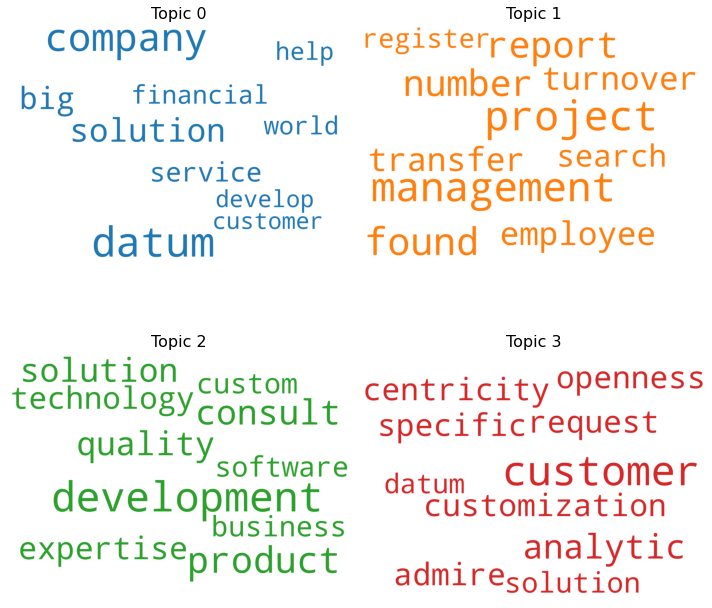

In [28]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [41]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\software\python\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.156523  0.023392       1        1  38.798907
2     -0.060547 -0.106169       2        1  16.992394
1      0.083687  0.004473       3        1  15.952593
4      0.117860 -0.042572       4        1  15.192691
3      0.015524  0.120877       5        1  13.063414, topic_info=            Term       Freq      Total Category  logprob  loglift
42         datum  17.000000  17.000000  Default  30.0000  30.0000
12   development   9.000000   9.000000  Default  29.0000  29.0000
72      customer   8.000000   8.000000  Default  28.0000  28.0000
219      digital   5.000000   5.000000  Default  27.0000  27.0000
4        company  15.000000  15.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
414       widget   0.699819   1.336447   Topic5  -5.0418   1.3884
72      customer   3.942625   8.855856   Topic5  -3.3130   1.2261
85      analytic   2.532953   6.039060   Topic5  -3.7555   1.1665
33      solution   1.741258  14.670949   Topic5  -4.1303  -0.0959
42         datum   1.582322  17.273026   Topic5  -4.2260  -0.3549

[206 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
257       2  0.570975       able
257       3  0.570975       able
68        1  0.785370     access
262       3  0.786671   addition
421       5  0.725377     admire
...     ...       ...        ...
184       1  0.865013       well
414       5  0.748253     widget
185       1  0.862705      world
38        2  0.565903  worldwide
186       1  0.909250       year

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [37]:
text=pd.read_csv('description.csv')
text=text['description']

In [38]:
import time
start_time = time.time()
analyzer = SentimentIntensityAnalyzer()
pos=[]
comp=[]
neg=[]
neu=[]
for sentence in text:
    if sentence==None:
       pos.append(0.5)
       comp.append(0.5)
    else:
        vs = analyzer.polarity_scores(sentence)
 
        pos.append(vs['pos'])
        comp.append(vs['compound'])
        neu.append(vs['neu'])
        neg.append(vs['neg'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.028522014617919922 seconds ---


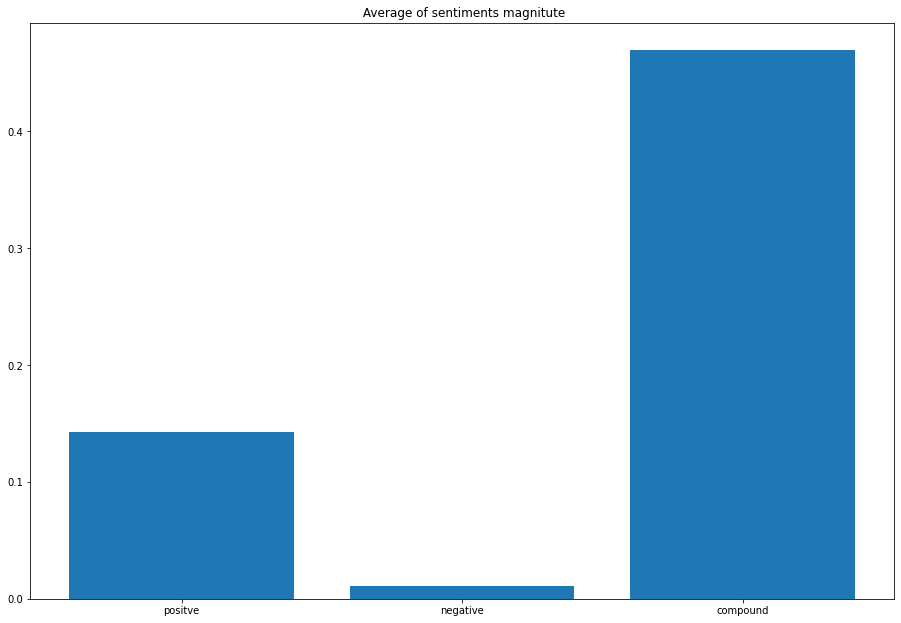

In [39]:
import matplotlib.pyplot as plt
X = ['Sentiments']
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([1,1,2,2])
labels = ['positve','negative','compound']
averages = [np.mean(pos),np.mean(neg),np.mean(comp)]
ax.bar(labels,averages)
ax.set_title(" Average of sentiments magnitute")
plt.show()

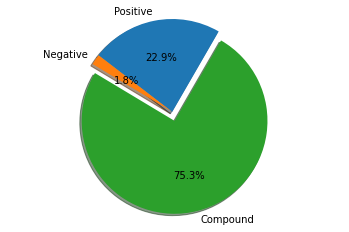

In [40]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Positive', 'Negative', 'Compound'
sizes = [np.mean(pos), np.mean(neg), np.mean(comp), ]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60,normalize=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()